# Real Estate Regression
### Building a Regression Model to Predict Housing Prices in NY City 
### Jackson Patrick & Trevor Chartier

## Introduction

TODO Paragraph Describing the project (high-level overview)

### Project Responsibilities Breakdown

#### Trevor
* TODO
* TODO
#### Jackson
* TODO
* TODO

## Part 1: Data Processing

In [64]:
%pip install geopy geohash2
%pip install geopy
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import geohash2 as geohash
from scipy.spatial import cKDTree
from geopy.distance import geodesic
import pandas.api.types as pd_types

pd.set_option('display.max_rows', 15)

### Read In Dataset

In [66]:

house_df = pd.read_csv("data/NY-House-Dataset.csv")
print(house_df.shape[0], " samples, ", house_df.shape[1], " features")
house_df.head()

4801  samples,  17  features


,BROKERTITLE,TYPE,PRICE,BEDS,BATH,PROPERTYSQFT,ADDRESS,STATE,MAIN_ADDRESS,ADMINISTRATIVE_AREA_LEVEL_2,LOCALITY,SUBLOCALITY,STREET_NAME,LONG_NAME,FORMATTED_ADDRESS,LATITUDE,LONGITUDE
0,Brokered by Douglas Elliman -111 Fifth Ave,Condo for sale,315000,2,2.000000,1400.0,2 E 55th St Unit 803,"New York, NY 10022","2 E 55th St Unit 803New York, NY 10022",New York County,New York,Manhattan,East 55th Street,Regis Residence,"Regis Residence, 2 E 55th St #803, New York, N...",40.761255,-73.974483
1,Brokered by Serhant,Condo for sale,195000000,7,10.000000,17545.0,Central Park Tower Penthouse-217 W 57th New Yo...,"New York, NY 10019",Central Park Tower Penthouse-217 W 57th New Yo...,United States,New York,New York County,New York,West 57th Street,"217 W 57th St, New York, NY 10019, USA",40.766393,-73.980991
2,Brokered by Sowae Corp,House for sale,260000,4,2.000000,2015.0,620 Sinclair Ave,"Staten Island, NY 10312","620 Sinclair AveStaten Island, NY 10312",United States,New York,Richmond County,Staten Island,Sinclair Avenue,"620 Sinclair Ave, Staten Island, NY 10312, USA",40.541805,-74.196109
3,Brokered by COMPASS,Condo for sale,69000,3,1.000000,445.0,2 E 55th St Unit 908W33,"Manhattan, NY 10022","2 E 55th St Unit 908W33Manhattan, NY 10022",United States,New York,New York County,New York,East 55th Street,"2 E 55th St, New York, NY 10022, USA",40.761398,-73.974613
4,Brokered by Sotheby's International Realty - E...,Townhouse for sale,55000000,7,2.373861,14175.0,5 E 64th St,"New York, NY 10065","5 E 64th StNew York, NY 10065",United States,New York,New York County,New York,East 64th Street,"5 E 64th St, New York, NY 10065, USA",40.767224,-73.969856


### Feature Engineering: Distance to Nearest Subway Station

Before analyzing the dataset and it's features, we would like to add one additional feature based on longitude and latitude -- the distance from the property to the nearest subway station.

In [67]:
subway_df = pd.read_csv("data/MTA_Subway_Stations.csv")
subway_df = subway_df[["GTFS Latitude", "GTFS Longitude"]]
subway_df.rename(columns={"GTFS Latitude": "Latitude", "GTFS Longitude":"Longitude"}, inplace=True)
print(subway_df.shape[0], " Subway Stations Included in NYC Dataset")
subway_df.head()

496  Subway Stations Included in NYC Dataset


,Latitude,Longitude
0,40.725915,-73.994659
1,40.588841,-73.983765
2,40.834255,-73.851222
3,40.680596,-73.955827
4,40.718315,-73.987437


In [68]:
subway_coords = subway_df[['Latitude','Longitude']].values
subway_tree = cKDTree(subway_coords)

subway_distances = []

for _, property in house_df.iterrows():
    property_coord = (property["LATITUDE"], property["LONGITUDE"])
    
    distance, idx = subway_tree.query([property["LATITUDE"], property["LONGITUDE"]])
    
    nearest_subway_coord = subway_coords[idx]
    precise_distance = np.round(geodesic(property_coord, nearest_subway_coord).miles,6)
    subway_distances.append(precise_distance)
    
house_df["NEAREST_SUB_STATION"] = subway_distances

In [69]:
house_df.head()

,BROKERTITLE,TYPE,PRICE,BEDS,BATH,PROPERTYSQFT,ADDRESS,STATE,MAIN_ADDRESS,ADMINISTRATIVE_AREA_LEVEL_2,LOCALITY,SUBLOCALITY,STREET_NAME,LONG_NAME,FORMATTED_ADDRESS,LATITUDE,LONGITUDE,NEAREST_SUB_STATION
0,Brokered by Douglas Elliman -111 Fifth Ave,Condo for sale,315000,2,2.000000,1400.0,2 E 55th St Unit 803,"New York, NY 10022","2 E 55th St Unit 803New York, NY 10022",New York County,New York,Manhattan,East 55th Street,Regis Residence,"Regis Residence, 2 E 55th St #803, New York, N...",40.761255,-73.974483,0.084535
1,Brokered by Serhant,Condo for sale,195000000,7,10.000000,17545.0,Central Park Tower Penthouse-217 W 57th New Yo...,"New York, NY 10019",Central Park Tower Penthouse-217 W 57th New Yo...,United States,New York,New York County,New York,West 57th Street,"217 W 57th St, New York, NY 10019, USA",40.766393,-73.980991,0.120612
2,Brokered by Sowae Corp,House for sale,260000,4,2.000000,2015.0,620 Sinclair Ave,"Staten Island, NY 10312","620 Sinclair AveStaten Island, NY 10312",United States,New York,Richmond County,Staten Island,Sinclair Avenue,"620 Sinclair Ave, Staten Island, NY 10312, USA",40.541805,-74.196109,0.605279
3,Brokered by COMPASS,Condo for sale,69000,3,1.000000,445.0,2 E 55th St Unit 908W33,"Manhattan, NY 10022","2 E 55th St Unit 908W33Manhattan, NY 10022",United States,New York,New York County,New York,East 55th Street,"2 E 55th St, New York, NY 10022, USA",40.761398,-73.974613,0.090788
4,Brokered by Sotheby's International Realty - E...,Townhouse for sale,55000000,7,2.373861,14175.0,5 E 64th St,"New York, NY 10065","5 E 64th StNew York, NY 10065",United States,New York,New York County,New York,East 64th Street,"5 E 64th St, New York, NY 10065, USA",40.767224,-73.969856,0.247496


In [70]:
print(len(list(house_df.columns)), "total features after feature engineering")
print("Features: ", list(house_df.columns))

18 total features after feature engineering
Features:  ['BROKERTITLE', 'TYPE', 'PRICE', 'BEDS', 'BATH', 'PROPERTYSQFT', 'ADDRESS', 'STATE', 'MAIN_ADDRESS', 'ADMINISTRATIVE_AREA_LEVEL_2', 'LOCALITY', 'SUBLOCALITY', 'STREET_NAME', 'LONG_NAME', 'FORMATTED_ADDRESS', 'LATITUDE', 'LONGITUDE', 'NEAREST_SUB_STATION']


### Analysis of Numerical Features

In [71]:
# Defining a function to group underrepresented categoreies into an "Other" category

def group_rare_categories(column, cutoff=0.01):
    if "Other" in house_df[column].unique(): 
        pass # Prevent from running the grouping twice
    
    category_proportions = house_df[column].value_counts(normalize=True)
    house_df.loc[house_df[column].map(category_proportions < cutoff), column] = "Other"
    

# Defining a function to safely drop columns (in case certain cells get run twice)
def drop_column(column_name):
    if column_name in house_df.columns:
        house_df.drop(column_name, axis=1, inplace=True)

#### Missing Values

It appears that in this dataset, missing values are filled in with the mean value for the column

We want to identify columns with potentially large numbers of missing values

In [72]:
columns = []
num_mean = []
means = []


def equal_to_mean(colName):
    mean_val = np.mean(house_df[colName])
    is_close = np.isclose(house_df[colName], mean_val, atol=1e-9)
    return is_close

for column in house_df:
    if(pd_types.is_numeric_dtype(house_df[column])):
        columns.append(column)
        total = sum(equal_to_mean(column))
        num_mean.append(total)
        means.append(np.round(np.mean(house_df[column]),2))

df = pd.DataFrame({"Column": columns, "Instances of Mean Value of Column": num_mean, "Mean Value of Column": means})
df

,Column,Instances of Mean Value of Column,Mean Value of Column
0,PRICE,0,2356940.17
1,BEDS,0,3.36
2,BATH,302,2.37
3,PROPERTYSQFT,1621,2184.21
4,LATITUDE,21,40.71
5,LONGITUDE,28,-73.94
6,NEAREST_SUB_STATION,0,0.69


BATH and PROPERTYSQFT have a large number of missing values that will need to be dealt with accordingly. LATITUDE and LONGITUDE have some values that are equal to the mean, but we feel that it is possible these may be actual coordinate values, and there are few enough of them that we have decided to leave them as is.

In [73]:
# Replace imputed values with NaN for ease of various imputation techniques later
house_df.loc[equal_to_mean("BATH"), "BATH"] = np.nan
house_df.loc[equal_to_mean("PROPERTYSQFT"),"PROPERTYSQFT"] = np.nan

#### BEDS

Any values of BEDS that are not a multiple of 0.5 (ie 1, 1.5, 2, etc) :  False


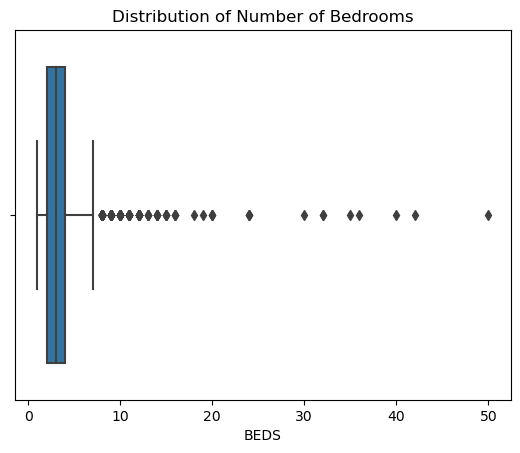

In [74]:
beds = house_df["BEDS"]

sns.boxplot(x=beds)
plt.title("Distribution of Number of Bedrooms");

print("Any values of BEDS that are not a multiple of 0.5 (ie 1, 1.5, 2, etc) : ", (beds % 0.5 != 0).any())

#### BATH

Any values of BATH that are not a multiple of 0.5 (ie 1, 1.5, 2, etc) :  False


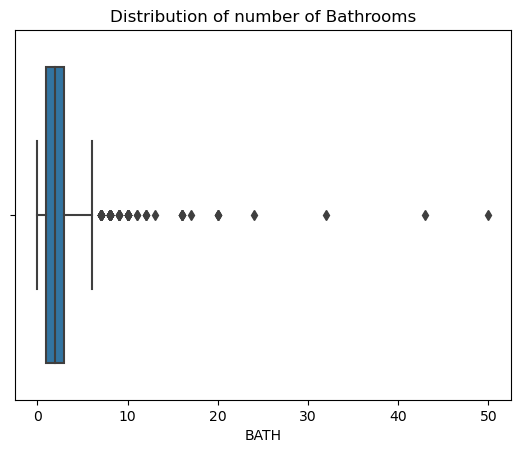

In [75]:
bath = house_df["BATH"]
sns.boxplot(x=bath)
plt.title("Distribution of number of Bathrooms");

print("Any values of BATH that are not a multiple of 0.5 (ie 1, 1.5, 2, etc) : ", (beds % 0.5 != 0).any())

Both the number of bedrooms and number of bathrooms are discrete numerical variables. While most examples have fewer than 5 of each, there are some outliers all the way up to 50. I checked into some of these outlier properties individually and found that they were apartment buildings. 

#### PROPERTYSQFT

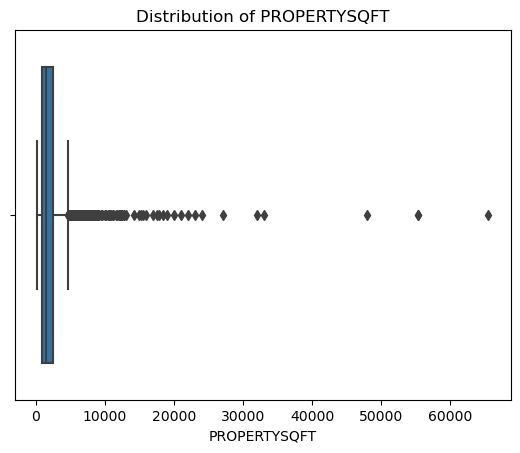

In [76]:
footage = house_df["PROPERTYSQFT"]
sns.boxplot(x=footage)
plt.title("Distribution of PROPERTYSQFT");

We checked into the maximum PROPERTYSQFT value address and it checks out as accurate

#### Label: PRICE

Address of outlier house:  6659-6675 Amboy Rd


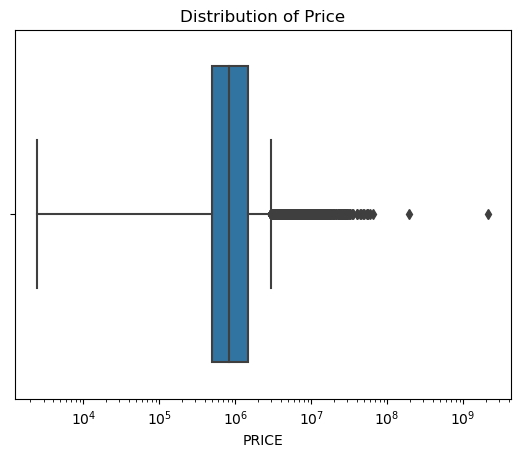

In [77]:
price = house_df["PRICE"]
sns.boxplot(x=price)
plt.xscale('log')
plt.title("Distribution of Price")
print("Address of outlier house: ", house_df.iloc[price.idxmax()]["ADDRESS"])

Wow, what an outlier. This outlier price is around 2.14 billion dollars. We investigated the address of this property and found that it was listed in 2023 for 2.49 million dolalrs. This price entry is clearly a mistake, so we will remove it.

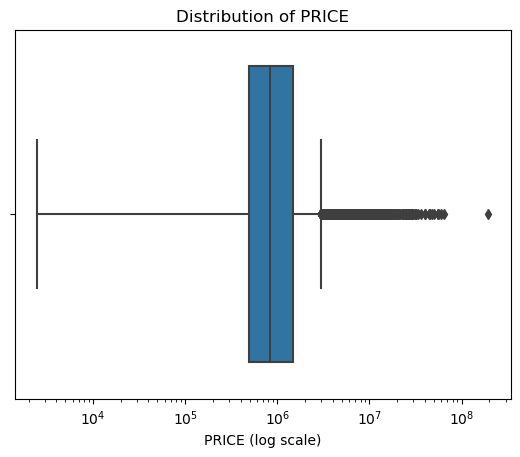

In [78]:
if price.idxmax() == 304:
    house_df.drop(index=price.idxmax(), inplace=True)
    
sns.boxplot(x=house_df["PRICE"])
plt.xscale('log')
plt.xlabel("PRICE (log scale)")
plt.title("Distribution of PRICE");

Price is on a log scale here. Notice the highest price now, 195 million — the central park tower penthouse suite. Not a data entry error!

#### LATITUDE & LONGITUDE

We have laready used these features to generate the feature of distance to nearest subway station.

We also found that including the raw values of latitude and longitude proved to be helpful for the model. To improve the benefit, we will transform the latitude and longitude values into a geohash column. The geohash column represents a spatial encoding of the property based on it's coordinates. This method transforms the location into an alphanumeric string. The length of the string (ie the precision), determines the size of the area it represents.

Below, we plot both the number of total unique geohash's and the number of geohash's that represent more than 1% of the samples as a function of geohash precision.



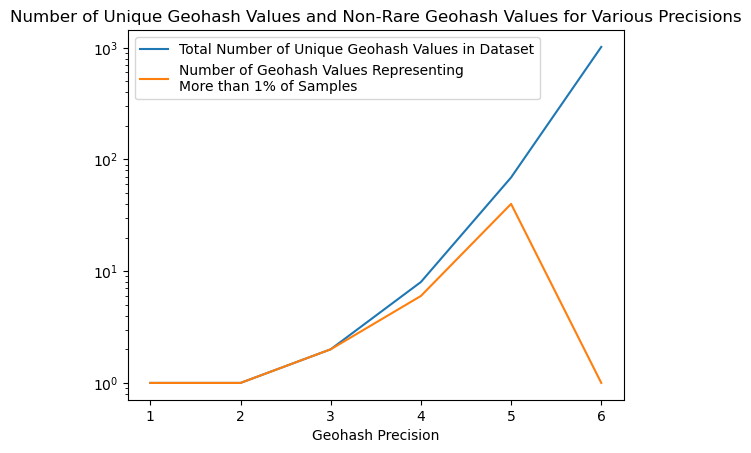

In [79]:
precisions = [1,2,3,4,5,6]
num_unique_non_rare_geohash = []
num_total_unique_geohash = []

for precision_val in precisions:
    geohash_col = house_df.apply(lambda row: geohash.encode(row["LATITUDE"], row["LONGITUDE"], precision=precision_val), axis=1)
    num_unique_non_rare_geohash.append((geohash_col.value_counts(normalize=True) > .01).sum())
    num_total_unique_geohash.append(len(geohash_col.unique()))
    
plt.plot(precisions, num_total_unique_geohash,label="Total Number of Unique Geohash Values in Dataset")
plt.plot(precisions, num_unique_non_rare_geohash, label="Number of Geohash Values Representing \nMore than 1% of Samples")
plt.yscale('log')
plt.title("Number of Unique Geohash Values and Non-Rare Geohash Values for Various Precisions")
plt.xlabel("Geohash Precision")
plt.legend();

As you might expect, as the precision increases, the number of unique geohash values increases exponentially. However, beyond a precision of 5 characters, the geohash value becomes exccessively granular. At this level of detail, each geohash may represent a very small region, often reducing its ability to group nearby locations meaningfully. Therefore, we will use a geohash precision of 5.

Unfortunately, after experimenting with our model, GEOHASH did not serve to improve performance, though it did significantly increase the complexity. We chose not to continue using the feature, but wanted to include the analysis in our notebook.

In [80]:
house_df["GEOHASH"] = house_df.apply(lambda row: geohash.encode(row["LATITUDE"], row["LONGITUDE"], precision=5), axis=1)
group_rare_categories(column="GEOHASH", cutoff=.01)

drop_column("GEOHASH") # This feature didn't help 

### Analysis of Categorical Features

Categorical features with very high cardinality, warrant inspection for the following reasons:
* Insufficient number of samples per category
* Increase of computational complexity to encode
* Lead to overfitting if model memorizes categories rather than learning patterns

In [81]:
categorical_columns = ['BROKERTITLE', 'TYPE', 'ADDRESS', 'STATE', 'MAIN_ADDRESS', 'ADMINISTRATIVE_AREA_LEVEL_2', 'LOCALITY', 'SUBLOCALITY', 'STREET_NAME', 'LONG_NAME', 'FORMATTED_ADDRESS']
cardinalities = []

for column in categorical_columns:
    cardinalities.append(len(house_df[column].unique()))
    
df = pd.DataFrame({"Categorical Feature" :categorical_columns, "Cardinality":cardinalities})
df

,Categorical Feature,Cardinality
0,BROKERTITLE,1035
1,TYPE,13
2,ADDRESS,4582
3,STATE,307
4,MAIN_ADDRESS,4582
5,ADMINISTRATIVE_AREA_LEVEL_2,29
6,LOCALITY,11
7,SUBLOCALITY,21
8,STREET_NAME,174
9,LONG_NAME,2731


#### BROKERTITLE

In [82]:
broker_counts = house_df["BROKERTITLE"].value_counts()
threshold = len(house_df) * .01 # Determine a "rare" category to be one with fewer than 1% of total examples
print(len(broker_counts[broker_counts > threshold]), "brokers have at least 1% of total samples")
print("Together, these 10 brokers represent ", broker_counts[broker_counts > threshold].sum(), "samples")
print("\nNumber of properties brokered by various brokers: ")
broker_counts

10 brokers have at least 1% of total samples
Together, these 10 brokers represent  1124 samples

Number of properties brokered by various brokers: 


Brokered by COMPASS                              456
Brokered by Douglas Elliman - 575 Madison Ave    110
Brokered by Brown Harris Stevens                  93
Brokered by Corcoran East Side                    91
Brokered by RE MAX Edge                           79
                                                ... 
Brokered by Blooming Realty                        1
Brokered by Five Towns Miller Realty Inc           1
Brokered by Genstone Properties                    1
Brokered by Nyc Elite Homes Inc                    1
Brokered by New York Way Real Estate Corp          1
Name: BROKERTITLE, Length: 1035, dtype: int64

There are some brokers with a significant number of samples in the dataset. Specifically, 10 brokers have at least 49 representative samples (1% of total). However, the vast majority of BROKERTITLE categories are rare (ie contain less than 1%) and many contain just a couple examples.

In [83]:
property_broker_counts = house_df["BROKERTITLE"].map(broker_counts)

print("Pearson Correlation: ", np.round(property_broker_counts.corr(house_df["PRICE"], method="pearson"),3))
print("Spearmen Correlation: ", np.round(property_broker_counts.corr(house_df["PRICE"], method="spearman"),3))
print("Kendall Correlation: ", np.round(property_broker_counts.corr(house_df["PRICE"], method="kendall"),3))


Pearson Correlation:  0.096
Spearmen Correlation:  0.234
Kendall Correlation:  0.16


The list property_broker_counts is a frequency encoding of BROKERTITLE. The low pearson correlation coefficient suggests no linear relationship between property_broker_counts and PRICE. However, the moderate values of Spearmen and Kendall correlation suggest some monotonic relationship between the number of properties sold by a broker and the PRICE. As one increases, so too does the other, but not at a constant rate. There seems to be some signal contained within the BROKERTITLE variable.

The high cardinality of BROKERTITLE, the large number of rare categories, and the seemingly ordinal relationship have led us to a few possibilities:
1. Group categories with fewer than 1% of representative samples into an "other" category
2. Use a frequency encoding
3. Encode BROKERTITLE into a BROKER_ACTIVITY feature containing the categories low activity, medium activity, and high activity

Option 1 will result in 11 total categories and rougly 3/4 of the data belonging to the "other" category. 
Option 2 will also result in a skewed distribution

Our judgement suggests that option 3 may be the most balanced solution that simplifies the feature's cardinality while maintaining the ordinal relationship, and limits highly skewed distributions. We did experiment with using option 1 by itself and in conjunction with option 3, but we ultimately found that using option 3 alone produced the best performing models.

In [84]:

if "BROKER_ACTIVITY" not in house_df.columns:
    broker_counts[broker_counts < 7] = 0 # Brokers with fewer than 7 examples are considered low
    broker_counts[(broker_counts <= 25) & (broker_counts >= 7)] = 1 # Brokers with between 7 and 25 are considered medium
    broker_counts[(broker_counts > 25) & (broker_counts <= 50)] = 2 # Brokers between 25 and 50 are considered high
    broker_counts[(broker_counts > 50)] = 3 # Brokers over 50 considered very high
    
    house_df["BROKER_ACTIVITY"] = house_df["BROKERTITLE"].map(broker_counts)
    drop_column("BROKERTITLE")

# Output distribution of categories
df = pd.DataFrame(house_df["BROKER_ACTIVITY"].value_counts())
df.reset_index(inplace=True)
df.columns = ["BROKER_ACTIVITY", "Number of Samples"]
df = df.sort_values(by="BROKER_ACTIVITY")
df["Activity Level"] = ['Low', 'Medium', 'High', "Very High"]
df = df[["Activity Level", "BROKER_ACTIVITY", "Number of Samples"]]
df

,Activity Level,BROKER_ACTIVITY,Number of Samples
0,Low,0,1707
1,Medium,1,1217
3,High,2,752
2,Very High,3,1124


Admittedly, the cutoff points of 7, 25, and 50 were somewhat arbitrary; however, we did try various values before finding ones that we were satisfied with the resulting class distribution. 

An alternative approach would have been to use values that perfectly divided the classes (or as close as possible), but we felt this was unecessary.

Additionaly, it is worth noting that we had orignally used 3 categories, with cutoff points of 7 and 25. However, including a 4th category for Very High activity (over 50 properties) seemed to improve model performance.

#### Type

In [85]:
type = house_df["TYPE"]
type_values = np.round(type.value_counts(normalize=True),3)
df = type_values.reset_index()
df.columns= ["TYPE", "Proportion of Samples"]
df

,TYPE,Proportion of Samples
0,Co-op for sale,0.302
1,House for sale,0.211
2,Condo for sale,0.186
3,Multi-family home for sale,0.151
4,Townhouse for sale,0.062
5,Pending,0.051
6,Contingent,0.018
7,Land for sale,0.010
8,For sale,0.004
9,Foreclosure,0.003


For TYPE, the cardinality isn't too high; however, there are some categories with an insuficcient number of samples. Condop for sale appears to be a typo, we will convert these to Condo for sale
To handle this feature, I will group categories under the 1% threshold into a singular "other" category.

In [86]:
house_df.loc[house_df["TYPE"] == "Condop for sale", "TYPE"] = "Condo for sale"
group_rare_categories(column="TYPE", cutoff=.01)

#### ADDRESS, MAIN_ADDRESS, FORMATTED_ADDRESS

Not only is there high multicolinearity between these features, but they are nearly unique to each observation, meaning there is nearly no predicitve power within these features. 

They may conatin useful information such as zip code or street name, but this information is also contained within other columns (which we will discuss later)

For these reasons, we have decided to drop these features.

In [87]:
drop_column("ADDRESS")
drop_column("MAIN_ADDRESS")
drop_column("FORMATTED_ADDRESS")

#### LONG_NAME

In [88]:
print(len(house_df["LONG_NAME"].unique()), " unique categories for LONG_NAME")

print("Number of Categories in LONG_NAME With at Least 1% of representative samples: ",(house_df["LONG_NAME"].value_counts(normalize=True) > .01).sum())

2731  unique categories for LONG_NAME
Number of Categories in LONG_NAME With at Least 1% of representative samples:  0


LONG_NAME has incredibly high cardinality. No categories are represented by at least 1% of the samples in the dataset. It will be dropped.

In [89]:
drop_column("LONG_NAME")

#### SUBLOCALITY

In [90]:
print("Unique Categories in SUBLOCALITY: ", list(house_df["SUBLOCALITY"].unique()))
counts = house_df["SUBLOCALITY"].value_counts().head(20)
print("\nValue Counts for the Top 20 Categories: ")
df = counts.reset_index()
df.columns= ["SUBLOCALITY", "Number of Samples"]
df

Unique Categories in SUBLOCALITY:  ['Manhattan', 'New York County', 'Richmond County', 'Kings County', 'New York', 'East Bronx', 'Brooklyn', 'The Bronx', 'Queens', 'Staten Island', 'Queens County', 'Bronx County', 'Coney Island', 'Brooklyn Heights', 'Jackson Heights', 'Riverdale', 'Rego Park', 'Fort Hamilton', 'Flushing', 'Dumbo', 'Snyder Avenue']

Value Counts for the Top 20 Categories: 


,SUBLOCALITY,Number of Samples
0,New York,1016
1,Kings County,727
2,Queens County,684
3,Queens,555
4,Richmond County,479
...,...,...
15,Brooklyn Heights,1
16,Jackson Heights,1
17,Rego Park,1
18,Fort Hamilton,1


SUBLOCALITY contains information on the boroughs and neighborhoods in NYC. I like this concept, especially the bouroughs, as this could capture some information about the socioeconomic status of the broad region of a property. However, after reviewing LONG_NAME and STATE_NAME I am concerned about the overall reliability of this feature and the mix of neighborhoods and bouroughs. 

I will drop this feature and instead use feature engineering from the zip-code to create a feature for bourough. 

In [91]:
drop_column("SUBLOCALITY")

#### LOCALITY

In [92]:
print("Unique Categories in LOCALITY: ", list(house_df["LOCALITY"].unique()))


Unique Categories in LOCALITY:  ['New York', 'New York County', 'The Bronx', 'Kings County', 'Bronx County', 'Queens County', 'Richmond County', 'United States', 'Brooklyn', 'Queens', 'Flatbush']


Dropping this column for the same reason as SUBLOCALITY

In [93]:
drop_column("LOCALITY")

#### STATE

In [94]:
state = house_df["STATE"]
print(len(state.unique()), " unique categories for STATE")
print("\nFirst Five State Entries: ")
state.head()

307  unique categories for STATE

First Five State Entries: 


0         New York, NY 10022
1         New York, NY 10019
2    Staten Island, NY 10312
3        Manhattan, NY 10022
4         New York, NY 10065
Name: STATE, dtype: object

STATE is a feature with high cardinality. It also appears that the end of each STATE string is the zip code. Let's focus on this part for now...

In [95]:
# Replace STATE Feature with extracted ZIP_CODE feature
house_df["zip"] = state.apply(lambda x: x.split()[-1])
print(len(house_df["zip"].unique()), "uniqe zip-code categories")

zip_values = house_df["zip"].value_counts(normalize=True)
print((zip_values > .01).sum(), " zip-codes have at least 1% of total samples")

178 uniqe zip-code categories
30  zip-codes have at least 1% of total samples


The zip-code may contain valuable information regarding price. First, we will map the zip-codes into the bouroughs of NYC they belong in.

In [96]:
# Load in a mapping from zip code to bourough
zip_borough_df = pd.read_csv("data/zip_borough.csv")
zip_borough_df["zip"] = zip_borough_df["zip"].astype(str)
zip_borough_df.head(3)

,zip,borough
0,10001,Manhattan
1,10002,Manhattan
2,10003,Manhattan


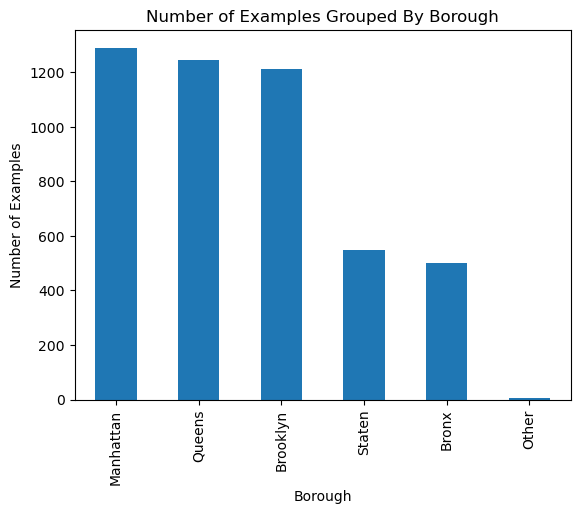

In [97]:
if 'BOROUGH' not in house_df.columns:
    house_df = house_df.merge(zip_borough_df, on="zip", how='left')
    house_df['BOROUGH'] = house_df['borough'].fillna('Other')
    drop_column('borough')
    drop_column("STATE")
    house_df = house_df.rename(columns={'zip':'ZIP'})
    
# Plot the resulting distribution   
borough_counts = house_df['BOROUGH'].value_counts()
borough_counts.plot(kind='bar')
plt.xlabel('Borough')
plt.ylabel("Number of Examples")
plt.title("Number of Examples Grouped By Borough");

After some experimentation, we found that Zip Code is also a valuable feature to include. However, to overcome the sparsity, we will group zip codes that have fewer than 1% of representative samples into an "other" category, similair to how we handled the TYPE feature.

In [98]:
group_rare_categories(column="ZIP", cutoff=.01)

#### STREET_NAME

In [99]:
print(len(house_df["STREET_NAME"].unique()), " unique categories for STREET_NAME")
print("\n10 Most Common Categories for STREET_NAME: ")
house_df["STREET_NAME"].value_counts(normalize=True).head(10)

174  unique categories for STREET_NAME

10 Most Common Categories for STREET_NAME: 


Manhattan          0.203958
Brooklyn           0.151458
Queens             0.142500
Staten Island      0.099792
The Bronx          0.064583
New York           0.059375
Flushing           0.028958
Forest Hills       0.012917
Bayside            0.008750
Jackson Heights    0.008750
Name: STREET_NAME, dtype: float64

It appears that STREET_NAME was extracted as the second token in the formatted address. Unfortunately, this seems to be an unreliable method to extract the street name and it instead appears to be a mix of street name, county, and state information.

At first, I thought this feature would be useless, but I decided to experiment with including it as a categorical feature and found that it was mostly redundant to the BOROUGH feature; however, the category "New York" was ranked third in feature importance on a preliminary random forest model. I will transform this column into a binary indicator for "New York".

In [100]:
house_df["NEW_YORK_INDICATOR"] = (house_df["STREET_NAME"] == "New York").astype(int)
drop_column("STREET_NAME")

#### ADMINISTRATIVE_AREA_LEVEL_2

In [101]:
house_df["ADMINISTRATIVE_AREA_LEVEL_2"].unique()

array(['New York County', 'United States', 'New York', 'Bronx County',
       '11214', '10301', '10309', '10303', '11234', '11414', '10310',
       '10003', '11417', '10304', 'Kings County', '10463',
       'Queens County', '10017', '10306', '10471', '11229', '10312',
       '11412', '10465', 'Brooklyn', '10002', '10466', '11237', '11218'],
      dtype=object)

This feature appears to be a mixture of zip-code, county, state, and country values. It appears to be unreliable and contains information already captured elsewhere, such as bourough. We will drop this feature.

In [102]:
drop_column("ADMINISTRATIVE_AREA_LEVEL_2")

In [103]:
print(len(list(house_df.columns)), "total features after data processing")
print(len(house_df), "total examples")

house_df.describe()

12 total features after data processing
4800 total examples


,PRICE,BEDS,BATH,PROPERTYSQFT,LATITUDE,LONGITUDE,NEAREST_SUB_STATION,BROKER_ACTIVITY,NEW_YORK_INDICATOR
count,4.800000e+03,4800.000000,4498.000000,3179.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000
mean,1.910039e+06,3.356042,2.373055,2181.749292,40.714268,-73.941542,0.687356,1.269375,0.059375
std,4.929167e+06,2.602054,2.010757,2918.158281,0.087639,0.101011,0.928088,1.173321,0.236350
min,2.494000e+03,1.000000,0.000000,230.000000,40.499546,-74.253033,0.011592,0.000000,0.000000
25%,4.990000e+05,2.000000,1.000000,955.000000,40.639512,-73.987143,0.174697,0.000000,0.000000
50%,8.250000e+05,3.000000,2.000000,1500.000000,40.726756,-73.949182,0.309017,1.000000,0.000000
75%,1.495000e+06,4.000000,3.000000,2451.500000,40.771924,-73.870638,0.723498,2.000000,0.000000
max,1.950000e+08,50.000000,50.000000,65535.000000,40.912729,-73.702450,5.514339,3.000000,1.000000


### Encoding Categorical Variables 



#### One Hot Encoding

The ordinal categorical variables, BOROUGH, ZIP,  and TYPE need to be encoded with OneHotEncoding

In [104]:
categorical_columns = ["TYPE", "BOROUGH","ZIP"]

if categorical_columns[0] in house_df.columns: # Prevent code from running twice
    house_df = pd.get_dummies(house_df, columns=categorical_columns)

    # Use k-1 encoding to prevent multicolinearity
    for column in categorical_columns:
        drop_column(column+"_Other")

print(house_df.shape[1], "total features after encoding.")

52 total features after encoding.


# Part 2: Model Training

In [105]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

#### Helper Methods

In [106]:
# For outputting and storing different model result metrics

results = []
def print_and_track_metrics(y_pred, y_actual, modelName):
    mae = np.round(mean_absolute_error(y_actual, y_pred),2)
    mse = np.round(mean_squared_error(y_actual,y_pred),2)
    rmse = np.round(np.sqrt(mse),2)
    medae = np.round(median_absolute_error(y_actual, y_pred),2)
    
    print("Mean Squared Error: ", mse)
    print("Root Mean Squared Error: ", rmse)
    print("Mean Absolute Error: ", mae)
    print("Median Absolute Error: ", medae)
    
    # Store Results
    results.append({"Model": modelName, "Mean Squared Error": mse,
                    "Root Mean Squared Error": rmse, "Mean Absolute Error": mae,
                    "Median Absolute Error":medae})
    

In [107]:
# For Visualizing Model Predicitions

def plot_results(y_test, y_pred, modelName):
    y_actual = y_test.reset_index(drop=True)
    plt.figure(figsize=(18,8))
    plt.plot(y_actual[:100]/1000, label="True Value", alpha=0.8)
    plt.plot(y_pred[:100]/1000, label="Predicted Value", alpha=0.8)
    plt.legend()
    plt.title("Predicted vs Actual Labels for the First 100 Test Examples\n Model: " + modelName)
    plt.ylabel("Price (Thousands of Dollars)")

### Imputation

Note: We experimented with various imputation techniques including median imputation, KNN Imputation, and RandomForest Imputation. These experiments were run on a baseline RandomForest Model with Default Parameters. In these experiments, the more complex imputation methods yielded no significant benefit in accuracy. Due to the higher complexity and the requirement of data standardization for KNN Imputation, we have decided to stick with median imputation.

In [127]:
X = house_df.drop("PRICE", axis=1)
y = house_df["PRICE"]

imputer = SimpleImputer(strategy='median')
X["BATH"] = imputer.fit_transform(X[["BATH"]])
X["PROPERTYSQFT"] = imputer.fit_transform(X[["PROPERTYSQFT"]])
X.head()

,BEDS,BATH,PROPERTYSQFT,LATITUDE,LONGITUDE,NEAREST_SUB_STATION,BROKER_ACTIVITY,NEW_YORK_INDICATOR,TYPE_Co-op for sale,TYPE_Condo for sale,TYPE_Contingent,TYPE_House for sale,TYPE_Land for sale,TYPE_Multi-family home for sale,TYPE_Pending,TYPE_Townhouse for sale,BOROUGH_Bronx,BOROUGH_Brooklyn,BOROUGH_Manhattan,BOROUGH_Queens,BOROUGH_Staten,ZIP_10003,ZIP_10011,ZIP_10014,ZIP_10016,ZIP_10019,ZIP_10021,ZIP_10022,ZIP_10023,ZIP_10024,ZIP_10025,ZIP_10028,ZIP_10065,ZIP_10128,ZIP_10301,ZIP_10304,ZIP_10306,ZIP_10312,ZIP_10314,ZIP_10463,ZIP_10471,ZIP_11201,ZIP_11209,ZIP_11215,ZIP_11229,ZIP_11234,ZIP_11235,ZIP_11360,ZIP_11372,ZIP_11374,ZIP_11375
0,2,2.0,1400.0,40.761255,-73.974483,0.084535,2,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7,10.0,17545.0,40.766393,-73.980991,0.120612,3,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4,2.0,2015.0,40.541805,-74.196109,0.605279,2,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,1.0,445.0,40.761398,-73.974613,0.090788,3,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,7,2.0,14175.0,40.767224,-73.969856,0.247496,3,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Standardization

In [ ]:
X_standardized = X.copy()

scaler = StandardScaler()
columns_to_standardize = ["BEDS", "BATH","LATITUDE", "LONGITUDE", "NEAREST_SUB_STATION","PROPERTYSQFT", "BROKER_ACTIVITY"]
X_standardized[columns_to_standardize] = scaler.fit_transform(X_standardized[columns_to_standardize])

### Mean Predictor Baseline Model

Mean Squared Error:  17499712732957.4
Root Mean Squared Error:  4183265.8
Mean Absolute Error:  1693932.77
Median Absolute Error:  1126184.14


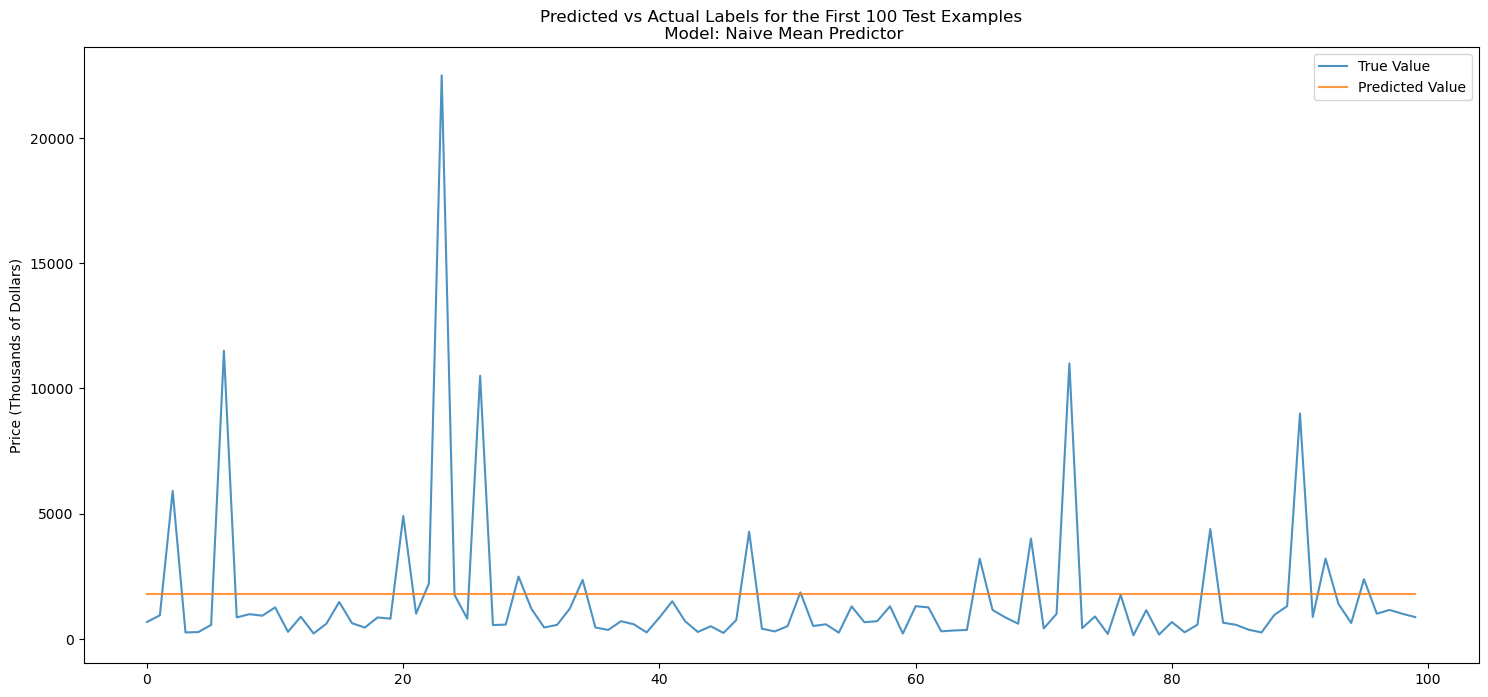

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

y_pred_naive = np.full(y_test.shape, np.mean(y_test))

print_and_track_metrics(y_pred_naive, y_test, "Naive Mean Predictor")

plot_results(y_test, y_pred_naive, "Naive Mean Predictor")


### KNearest Neighbor Regression

Mean Squared Error:  26297689369877.41
Root Mean Squared Error:  5128127.28
Mean Absolute Error:  1241730.34
Median Absolute Error:  262249.31


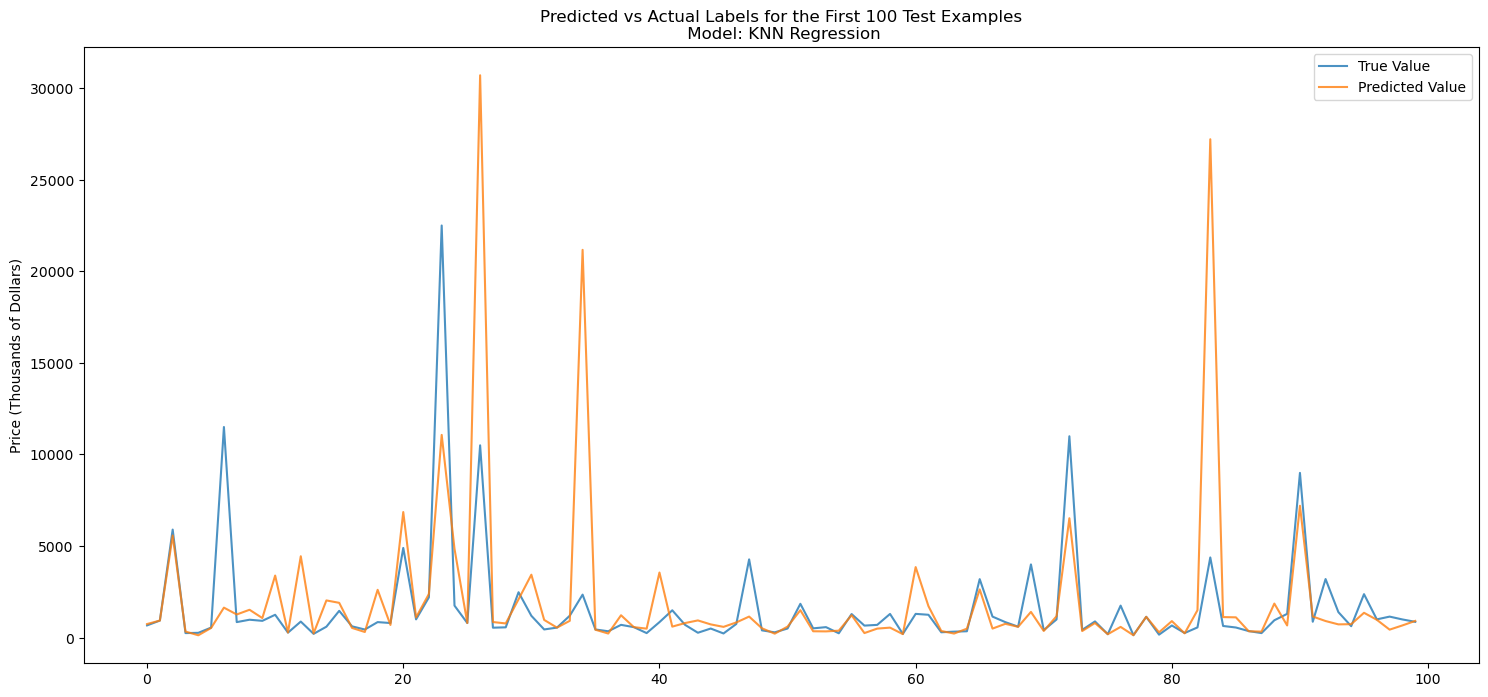

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_standardized, y, test_size=0.3, random_state=42)


knn = KNeighborsRegressor(n_neighbors=3, weights='distance')

knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print_and_track_metrics(y_pred_knn, y_test, "KNN Regression")
plot_results(y_test, y_pred_knn, "KNN Regression")

##### KNearest Neighbor Regression Hyper Parameter Optimization

In [ ]:
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(
    estimator=knn, 
    param_grid=param_grid
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print results
print("Best Parameters:", best_params)

# Predict with the best model
y_pred_best = best_model.predict(X_test)

# Evaluate the best model
print_and_track_metrics(y_pred_best, y_test, "Optimized KNN Regression")
plot_results(y_test, y_pred_best, "Optimized KNN Regression")

### SVM Regression

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

param_grid = {
    'C': [100,500,1000],        
    'epsilon': [0.0001,0.001, 0.01], 
    'gamma': [0.001, 0.01, 0.1, 1],  
    'kernel': ["rbf", "poly"],
    'degree': [2, 3, 4],  
    'coef0': [0, 0.5, 1]
}

svr_model = SVR(kernel='rbf')

grid_search = GridSearchCV(estimator=svr_model, param_grid=param_grid, cv=3, verbose=1, n_jobs=-1)

grid_search.fit(X_train,y_train)

print(f"Best parameters: {grid_search.best_params_}")

y_pred = grid_search.predict(X_test)

best = grid_search.best_estimator_
y_pred = best.predict(X_test)

print("Best Hyperparameters: ", grid_search.best_params_)

print_and_track_metrics(y_pred,y_test, "SVM Regression")
plot_results(y_test,y_pred, "SVM Regression")

### XGBoost

In [ ]:
X_xgb = X.copy()
y_xgb = y.copy()

X_train, X_test, y_train, y_test = train_test_split(X_xgb, y_xgb, test_size=0.3, random_state=42)

param_grid = {
    'n_estimators': [200],      
    'learning_rate': [0.05, 0.1, 0.15],   
    'max_depth': [6, 7, 8, 9],      
    'subsample': [0.7, 0.8, 0.9], 
    'colsample_bytree': [0.8, 1.0]       
}

xgb = XGBRegressor(random_state=42)

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring="neg_mean_squared_error",cv=3, verbose=1,n_jobs=-1)

grid_search.fit(X_train,y_train)

best = grid_search.best_estimator_

y_pred = best.predict(X_test)

print("Best Hyperparameters: ", grid_search.best_params_)
print_and_track_metrics(y_pred, y_test, "XGBRegreessor")

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Hyperparameters:  {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}
Mean Squared Error:  7693046384317.69
Root Mean Squared Error:  2773634.15
Mean Absolute Error:  718213.66
Median Absolute Error:  174144.66


### Random-Forest Regression

Baseline tests indicated Random-Forest Regression to be the most promising option. As such, we have placed the largest emphasis on tuning this model.

Fitting 2 folds for each of 7 candidates, totalling 14 fits
Best Parameters: {'feature_selection__n_features_to_select': 30}
Best Cross-Validation Score (Negative MAE): -14570135549271.07
Mean Squared Error:  5053739970763.64
Root Mean Squared Error:  2248052.48
Mean Absolute Error:  642814.1
Median Absolute Error:  153502.44


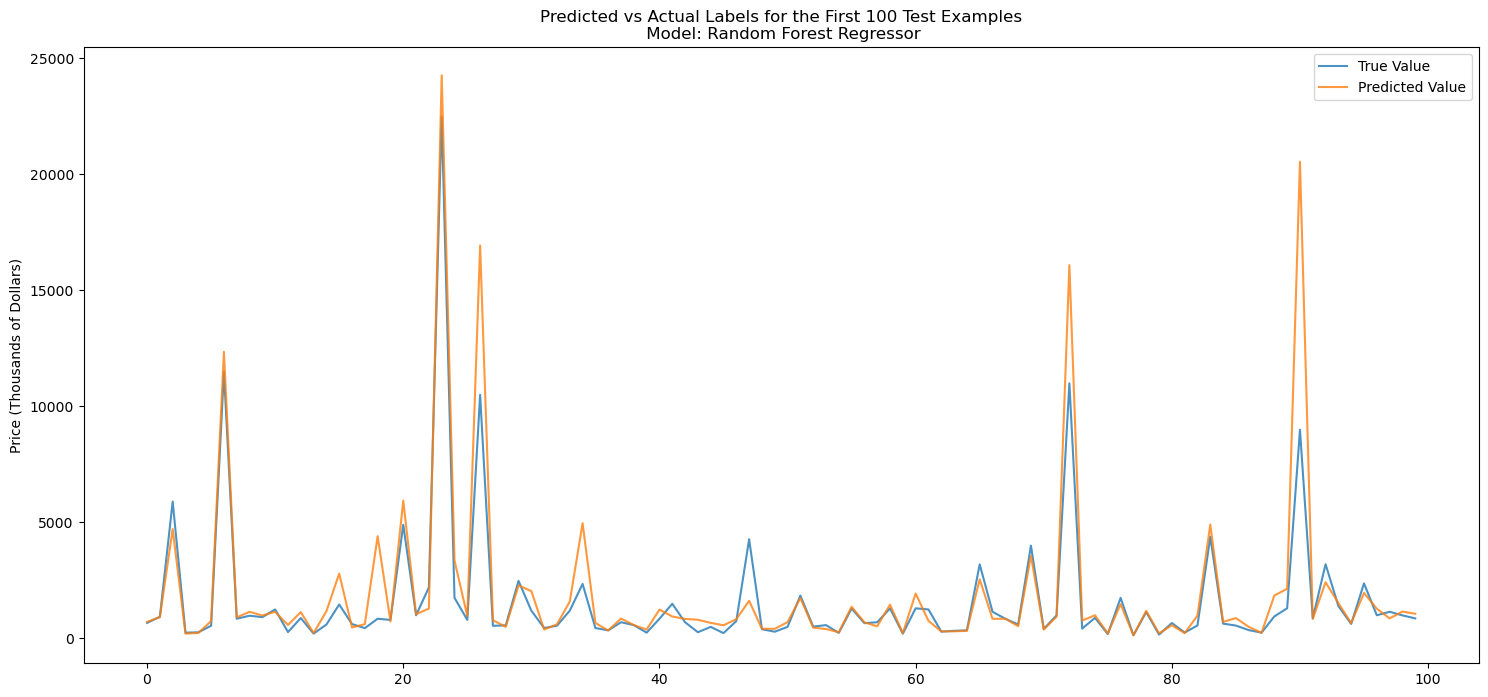

In [ ]:
X_rf = X.copy()
y_rf = y.copy()

X_train, X_test, y_train, y_test = train_test_split(X_rf, y_rf, test_size=0.3, random_state=42)

rf = RandomForestRegressor(n_estimators=100)
rfe = RFE(estimator=rf)

pipeline = Pipeline([
    ('feature_selection', rfe),
    ('model', rf)
])

param_grid = {
    'feature_selection__n_features_to_select': [15, 30, 45, 50],
    'model__max_depth': [None, 10, 20],            
    'model__min_samples_split': [2, 5, 10],     
    'model__min_samples_leaf': [1, 2, 4],         
    'model__max_features': ['sqrt', 'log2', None] 
}

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid,
                           cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score (Negative MAE):", grid_search.best_score_)

best = grid_search.best_estimator_

y_pred = best.predict(X_test)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print_and_track_metrics(y_pred,y_test, "Random Forest Regressor")
plot_results(y_test, y_pred, "Random Forest Regressor")

#### Feature Importance (Random Forest)

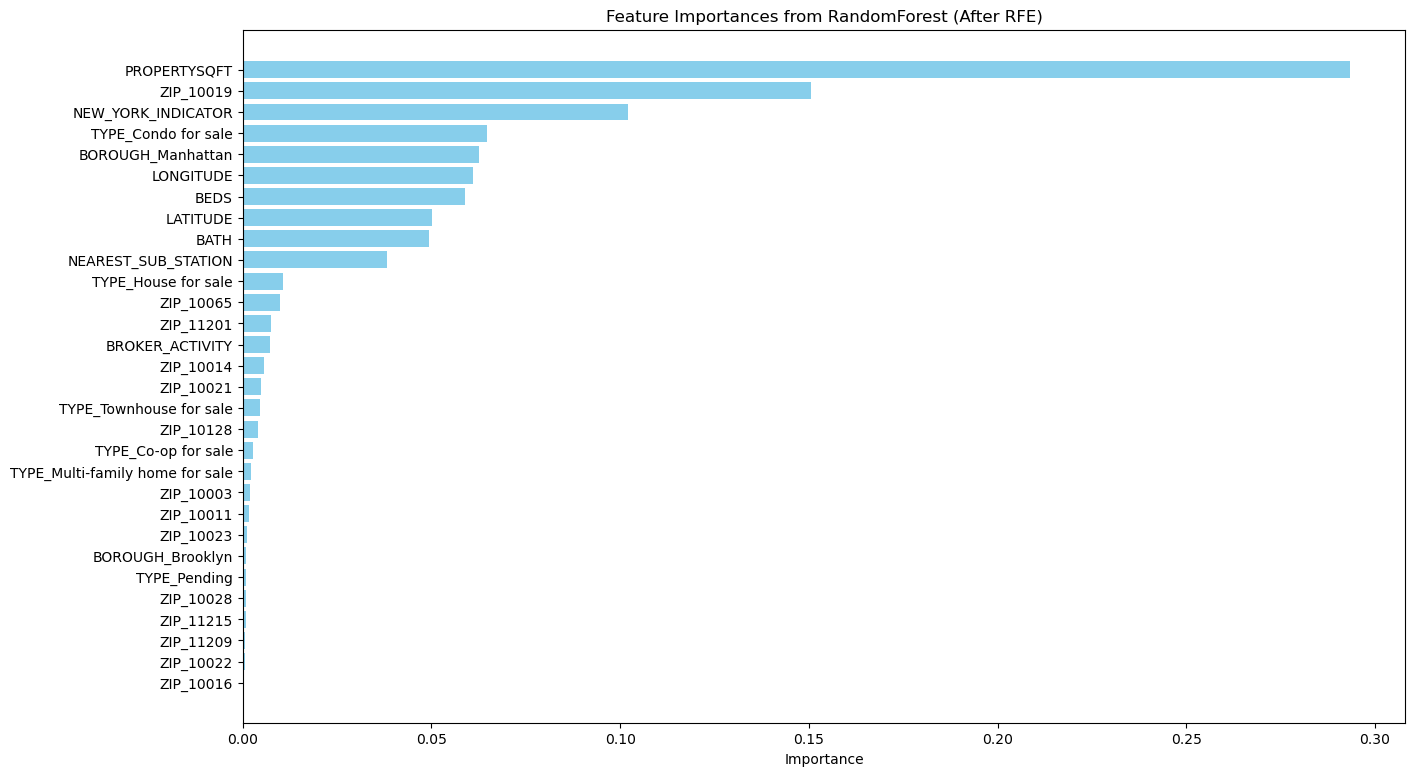

In [ ]:
importances = best.named_steps['model'].feature_importances_

selected_features = best.named_steps['feature_selection'].support_
feature_names = X_train.columns[selected_features]


sorted_idx = np.argsort(importances)[::-1] # sort importances in descending order


feature_importance = pd.DataFrame({
    'Feature': feature_names[sorted_idx],
    'Importance': importances[sorted_idx] 
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(15,9))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances from RandomForest (After RFE)')
plt.gca().invert_yaxis()  
plt.show()

### Analysis of Results

In [140]:
pd.DataFrame(results)

,Model,Mean Squared Error,Root Mean Squared Error,Mean Absolute Error,Median Absolute Error
0,Naive Mean Predictor,1.749971e+13,4183265.80,1693932.77,1126184.14
1,KNN Regression,2.629769e+13,5128127.28,1241730.34,262249.31
2,Random Forest Regressor,5.053740e+12,2248052.48,642814.10,153502.44


Notice how mean absolute error is much larger than mediadn absolute error. This suggests that there are some very large outlier residual values that bring up the MAE but have less of an impact on the median. This could be happening on some of the very expensive properties (in the tens or hundereds of millions of dollars).